In [10]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


In [11]:
DATASET_NAME="pick_miss_cup"

## Intorduction

As in data analysis we first need to load the data and perform all the normalization and optimizations. The normalized data after all will be passed through encoder part of trained autoencoder just to get only relavent features in the data. 

So let's start with data loading:

##### Normal data

In [12]:
import pandas

DATA = pandas.read_csv('../../../robot-data/new_data/normal/merged_normal_pick.csv')
DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,shoulder2_joint position,torso_joint position,left_wheel_joint effort,right_finger_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity
0,4,284,0.264902,1.264027e-02,12,6456,0.071533,0,0,0,...,2.183829,0.301,0.0,-0.02690,0.0,-0.064453,92.853043,0.032227,0.0,0.0
1,5,355,0.200013,4.539819e-05,14,7532,0.069651,1,93,0,...,2.183829,0.301,0.0,-0.02421,0.0,-0.080566,82.853053,0.008057,0.0,0.0
2,5,355,0.201024,3.146104e-06,12,6456,0.087292,0,0,0,...,2.183829,0.298,0.0,-0.02421,0.0,0.000000,88.853035,0.052368,0.0,0.0
3,5,355,0.200395,2.509922e-06,11,5918,0.086181,1,93,0,...,2.183829,0.303,0.0,-0.02421,0.0,0.000000,104.853008,0.032227,0.0,0.0
4,5,355,0.200118,1.580059e-06,13,6994,0.081231,0,0,1,...,2.183829,0.299,0.0,-0.02690,0.0,-0.112793,90.853009,0.008057,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,5,610,0.200005,3.723324e-07,15,8070,0.067330,0,0,1,...,2.183880,0.277,0.0,0.46268,0.0,0.000000,-85.098008,0.056396,0.0,0.0
1672,5,610,0.200002,2.663688e-08,15,8070,0.066322,1,93,2,...,2.183880,0.272,0.0,0.45999,0.0,0.000000,-78.543533,0.060425,0.0,0.0
1673,5,610,0.199537,8.526598e-07,15,8070,0.068983,0,0,1,...,2.183880,0.268,0.0,0.45999,0.0,0.048340,-75.750176,0.060425,0.0,0.0
1674,5,610,0.198214,1.329264e-05,15,8070,0.066772,1,93,1,...,2.183880,0.263,0.0,0.45999,0.0,0.000000,-72.689521,0.060425,0.0,0.0


##### Anomaly data

In [13]:
ANOMALY_DATA = pandas.read_csv('../../../robot-data/new_data/test/merged_pick_miss_cup.csv')
ANOMALY_DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,left_wheel_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity,right_wheel_joint velocity,shoulder1_joint velocity,shoulder2_joint velocity
0,6,120,0.190663,1.291337e-02,12,6456,0.063092,0,0,0,...,0.0,0.0,0.000000,-7.569872,0.000000,0.0,0.0,0.0,0.000000,0.0
1,5,100,0.199080,3.438309e-06,15,8070,0.065023,0,0,0,...,0.0,0.0,0.000000,-1.429256,0.008057,0.0,0.0,0.0,0.000000,0.0
2,5,100,0.200019,1.036475e-05,16,8608,0.064299,1,93,0,...,0.0,0.0,0.000000,-7.379467,0.000000,0.0,0.0,0.0,0.000000,0.0
3,5,100,0.199980,1.747321e-05,14,7532,0.070981,0,0,0,...,0.0,0.0,0.000000,-1.260519,0.008057,0.0,0.0,0.0,0.000000,0.0
4,5,100,0.200011,4.932453e-08,15,8070,0.064694,1,93,0,...,0.0,0.0,0.000000,-3.198487,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,5,360,0.199993,1.427605e-08,15,8070,0.068399,0,0,1,...,0.0,0.0,-0.064453,-81.999998,0.056396,0.0,0.0,0.0,0.000000,0.0
1686,5,360,0.199986,9.456916e-08,14,7532,0.069274,1,93,0,...,0.0,0.0,-0.128906,-87.999980,0.056396,0.0,0.0,0.0,0.000000,0.0
1687,5,360,0.199958,1.688842e-08,14,7532,0.074080,0,0,0,...,0.0,0.0,-0.064453,-82.051771,0.056396,0.0,0.0,0.0,0.000000,0.0
1688,5,360,0.199994,1.212901e-06,14,7532,0.067554,1,93,1,...,0.0,0.0,-0.048340,-91.781406,0.056396,0.0,0.0,0.0,0.000209,0.0


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math
import pickle

## Data processing

#### Data processing utils

In [15]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)

def draw_from_GMM(mus, sigmas, thetas, numOfDraws = 1):
    """
    This function draws samples based on mu, sigma and theta of Gaussian Mixture Model
    :param mus: list of mus
    :param sigmas: list of sigmas
    :param thetas: list of thetas
    :param numOfDraws: number of draws from distribution
    :return: list of samples and list of lists of samples
    """
    gmm_res = []
    gaussians = []
    for j in range(len(thetas[0])):
        gaussians.append([])
    for i in tqdm(range(len(mus))):
        mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
        samples = np.random.normal(mus[i,mixture_idx], sigmas[i,mixture_idx], size=numOfDraws)
        sample_index = np.random.choice(len(samples), size=1, replace=True)[0]
        gmm_res.append(samples[sample_index]) 
        gaussians[mixture_idx].append(samples[sample_index])
    return gmm_res, gaussians

def calc_lppd(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in tqdm(range(len(y))):
        ppd_res = 0
        for i in range(len(mus)):
            mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
            ppd_res += norm.pdf(y[n], mus[i, mixture_idx], sigmas[i, mixture_idx])
        lppds.append(math.log(ppd_res/len(mus))) 
        
    return lppds, np.sum(lppds)

def calc_lppd_vec(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in range(len(y)):
        ppd_res = 0
        pdf = norm.pdf(y[n], mus, sigmas)
        ppd_res = np.sum(np.multiply(thetas, pdf))
        lppds.append(math.log(ppd_res/len(mus)))
    return lppds, np.sum(lppds)

def calc_lppd_vec_sliding_window(mu, sigma, theta, y, window_size=5):
    windows = np.lib.stride_tricks.sliding_window_view(y, window_size)
    wlppd = []
    for w in windows:
        lppds, lppd = calc_lppd_vec(mu, sigma, theta, w)
        wlppd.append(np.average(lppds))
    return wlppd, np.sum(wlppd)


    """
    Data split for train and labels with sliding window
    :param data: original data
    :param window: subsequence length
    :return:
    """
    train_x = data[:window + 1]
    x, y = sliding_windows(train_x, 1)
    train_x = Variable(torch.Tensor(np.array(x)))
    train_y = Variable(torch.Tensor(np.array(y)))
    return train_x, train_y


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)



#### Train Autoencoder

In [31]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
seq_len = 300
reduced_features = 2

def train_autoencoder(data):
    encoder = None
    if os.path.isdir('./stan/encoder_model.ml'):
        encoder = keras.models.load_model('./stan/encoder_model.ml')
    else:
        input_data = Input(shape=(data.shape[1],))
        encoded1 = Dense(128, activation='relu')(input_data)
        encoded2 = Dense(reduced_features, activation='relu')(encoded1)
        decoded1 = Dense(128, activation='relu')(encoded2)
        decoded2 = Dense(data.shape[1], activation=None)(decoded1)
        autoencoder = Model(input_data, decoded2)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        autoencoder.summary()
        autoencoder.fit(data, data,
                        epochs=500,
                        batch_size=16,
                        shuffle=True)
        encoder = Model(input_data, encoded2)
        encoder.save('./stan/encoder_model.ml')
    return encoder

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [22]:
norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)

columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print("Common columns:", anomaly_norm_data.shape)
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)

Common columns: (1690, 249)
Original dataset shape: (1676, 249)


In [32]:
encoder = train_autoencoder(norm_data)

In [33]:
new_data = encoder.predict(norm_data)
print(new_data.shape)

(1676, 2)


#### Running PCA and taking only two columns

In [17]:

pca = PCA(n_components=249)
new_data = pca.fit_transform(norm_data)
n_pcs = pca.n_components_
most_important = [[np.abs(pca.components_[i]).argmax(), np.abs(pca.components_[i]).max()] for i in range(n_pcs)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

Original dataset shape: (1676, 249)


,Index of column,PCA coefficient
0,154,0.912142
1,0,0.707107
2,9,0.683191
3,138,0.651615
4,245,0.642047
...,...,...
244,62,0.212874
245,105,0.209314
246,183,0.202046
247,216,0.178944


In [18]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
pandas.set_option("max_colwidth", 700)
most_important_column_names_df

,Column name
0,Counter(/kinect2/sd/image_depth_rect)
1,Counter(/arm_trajectory_controller/follow_joint_trajectory/status)
2,Counter(/detected_objects)
3,Mean_Consecutive(/kinect2/qhd/image_mono_rect/compressed)
4,rotation1_joint effort
...,...
244,Mean_Consecutive(/gripper_controller/current_gap)
245,Mean_Consecutive(/kinect2/hd/image_mono_rect/compressed)
246,Counter(/move_group/ompl/parameter_updates)
247,Mean_Consecutive(/rosout)


Density estimation
measure density of the data path (Deep density estimation)
simulation base inference

(1. PCA 2. To choose part of columns 3. Run pca again on chosen columns)
4. * Use autoencoder to reduce dimensions 
5. Read about dimensionality reduction
6. Map data to reduced dimentions
7. GMM with 2d
(PCA?) -> Autoencoder -> (normalizing flow for density estimation?) -> GMM-2D

(249, 249)
257


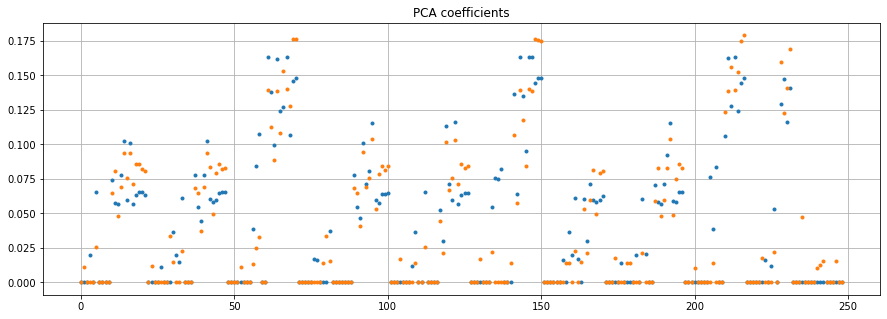

In [33]:
print(pca.components_.shape)
important_pca_comp = pca.components_[:2,:]
important_pca_comp = np.where(abs(important_pca_comp) <= 0.01, 0, important_pca_comp)
print(np.count_nonzero(important_pca_comp))
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_pca_comp.T), ".")
axs.set_title('PCA coefficients')
plt.grid()
plt.show()
plt.close()

As the result of filtering we got only 12 points which mean that we have only 12 features of the original data will play major role in the linear transformation on the data we perform next.

##### Building linear combinations from important PCA components and original normilized data

So we took the list of components from the above plot and we multiply them by original and anomly normalized data as we show next: 

$$x = [x_1, x_2,...,x_{73}]\\$$
$$a = [0,0,0,..,a_n,0,..,a_k,0,...a_m,0...]\\\\
\tilde{y} = x \cdot a$$

(1676, 2)
(1690, 2)


Text(0.5, 1.0, 'Lineary transformed data')

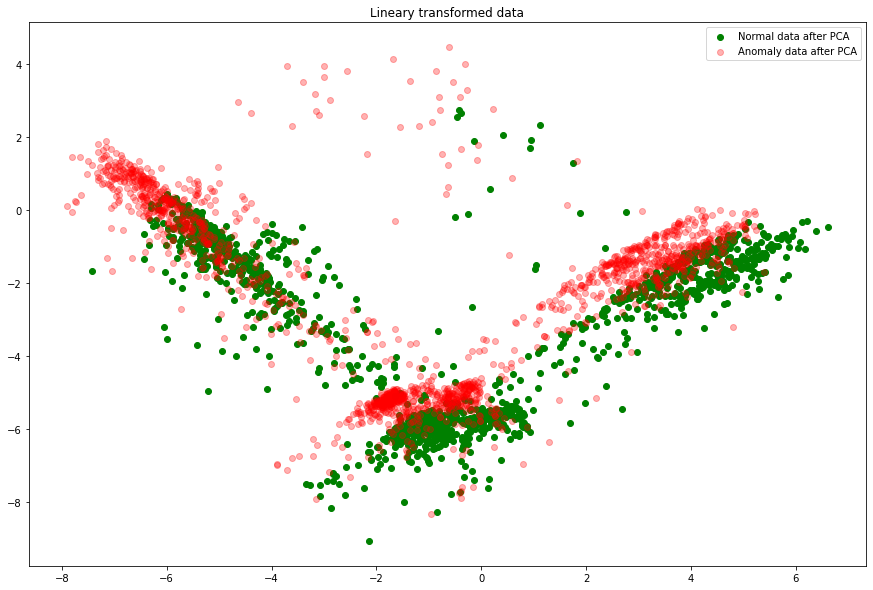

In [34]:
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_pca_data = important_pca_comp.dot(norm_data.T).T
anomaly_pca_data = important_pca_comp.dot(anomaly_norm_data.T).T
print(normal_pca_data.shape)
print(anomaly_pca_data.shape)
axs.scatter(normal_pca_data[:,0], normal_pca_data[:,1], color="g", label="Normal data after PCA")
axs.scatter(anomaly_pca_data[:,0], anomaly_pca_data[:,1], color="r", alpha=0.3, label="Anomaly data after PCA")
axs.legend()
axs.set_title('Lineary transformed data')

In [35]:
normal_pca_data_df = pandas.DataFrame(normal_pca_data, columns=['y1', 'y2'])
normal_pca_data_df

,y1,y2
0,2.973262,-3.879711
1,-2.858649,-8.150966
2,-1.180230,-6.350606
3,-4.094069,-4.895358
4,-0.932764,-6.128677
...,...,...
1671,3.901709,-1.652867
1672,-0.931986,-5.475619
1673,-1.244238,-5.912041
1674,-1.058517,-5.555667


##### PCA Results plot 

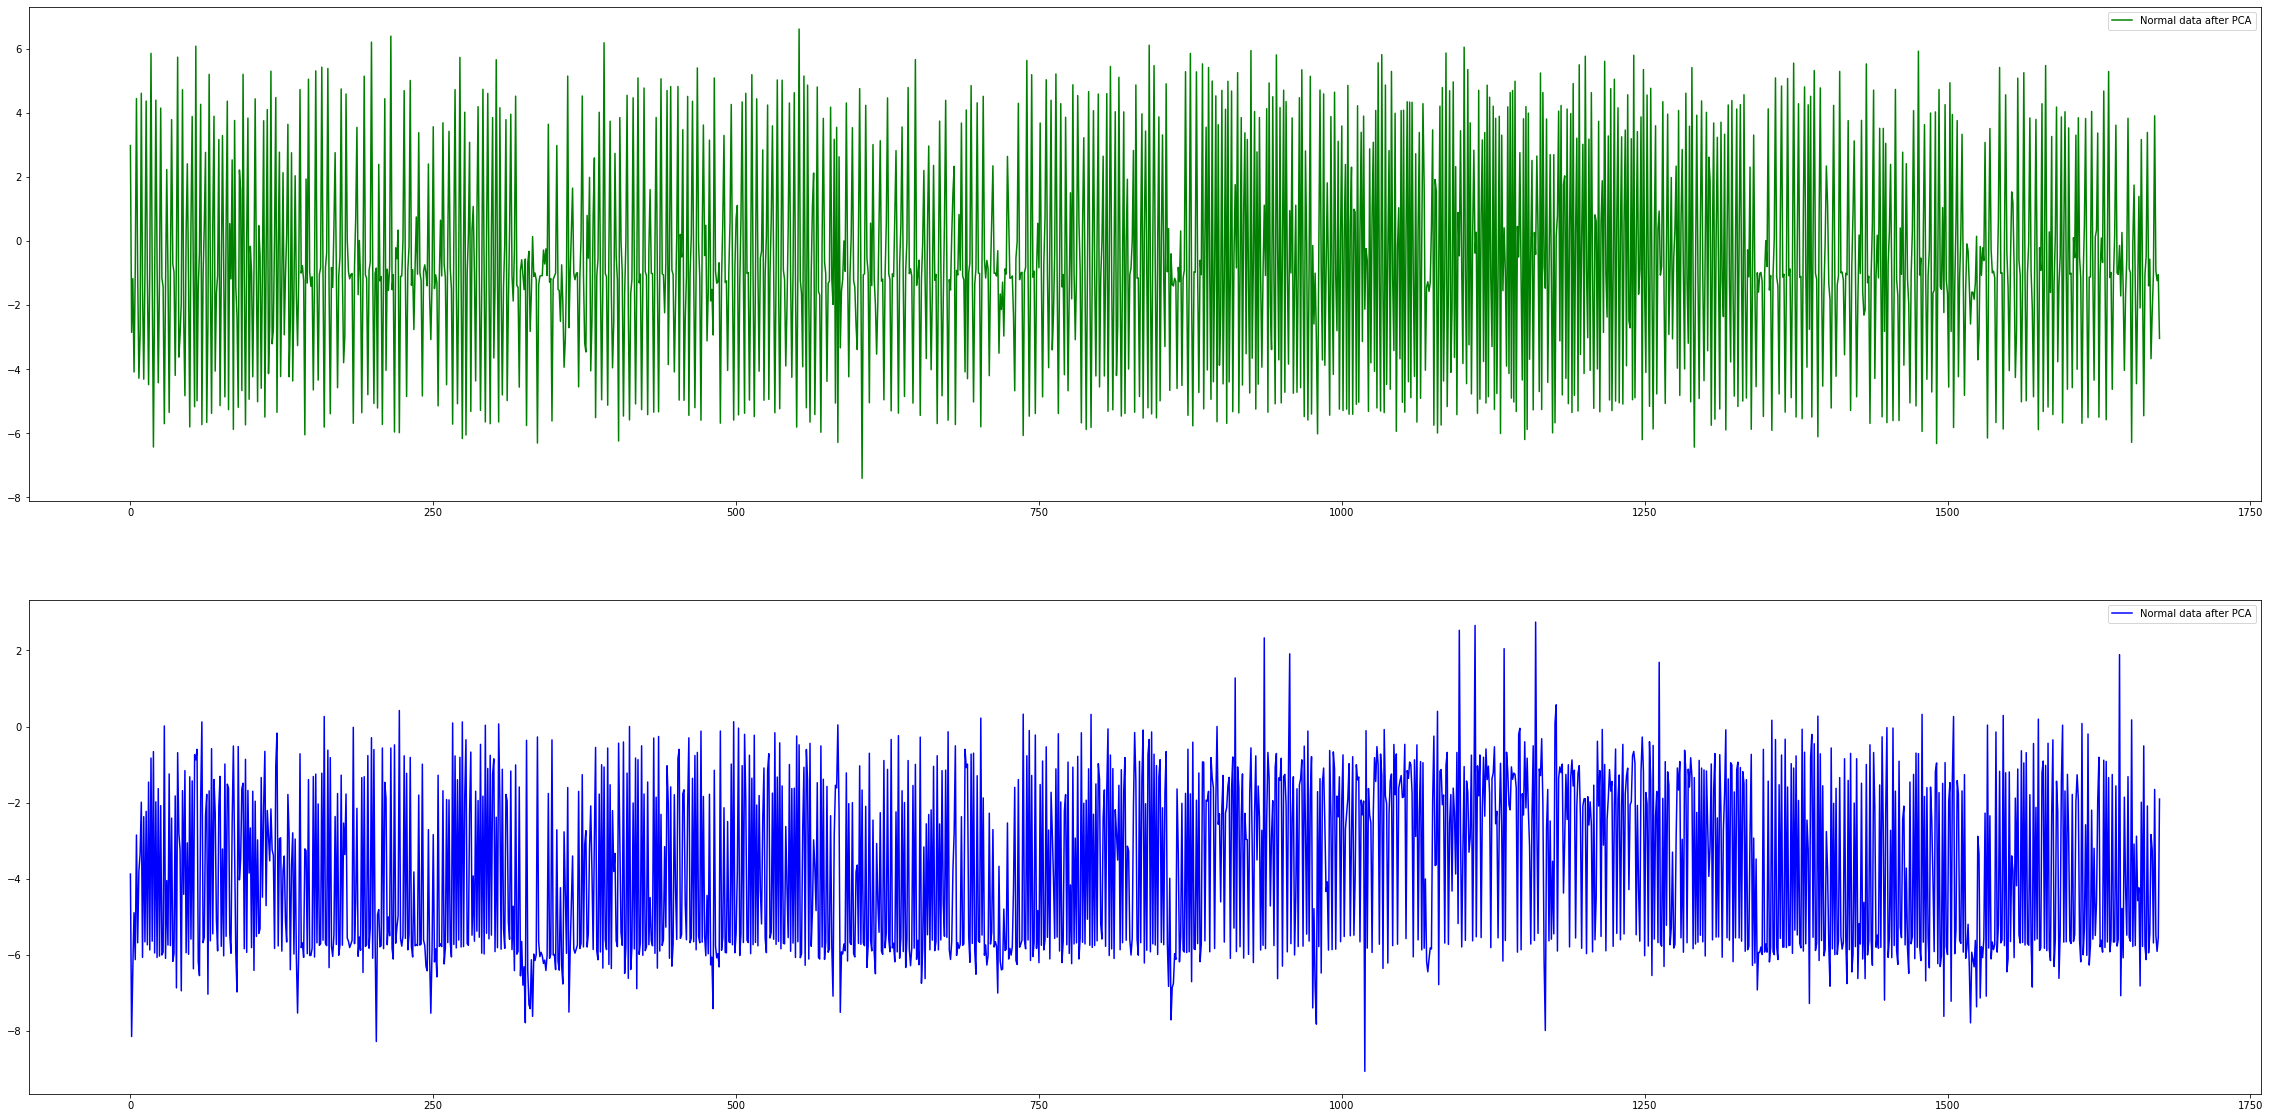

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), squeeze=False)
axs[0][0].plot(range(len(normal_pca_data[:,0])), normal_pca_data[:,0], color="g", label="Normal data after PCA")
axs[1][0].plot(range(len(normal_pca_data[:,1])), normal_pca_data[:,1], color="b", label="Normal data after PCA")
axs[0][0].legend()
axs[1][0].legend()

Just to understand behaviour of the data we decided to plot histogram

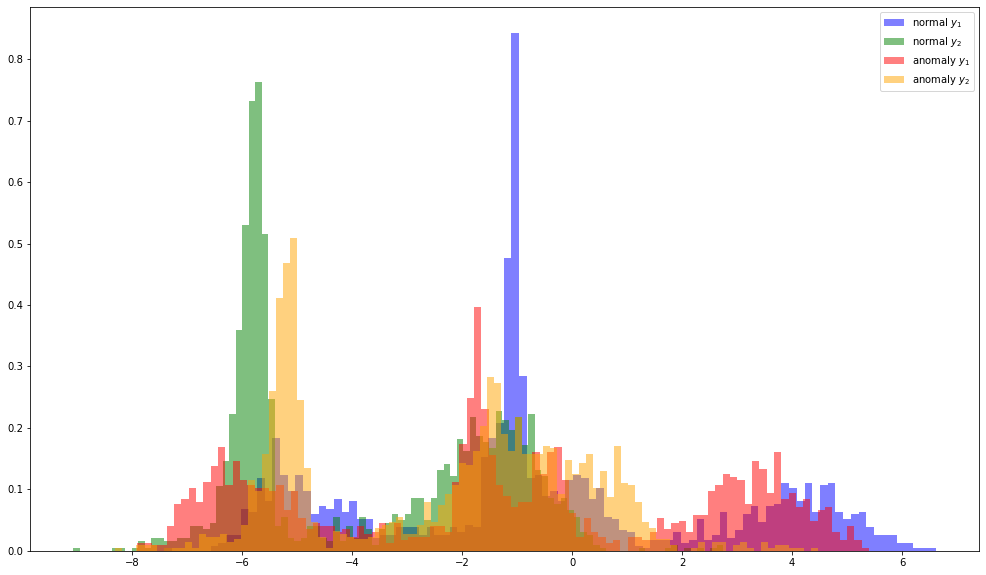

In [37]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_pca_data[:, 0]), 100, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(list(normal_pca_data[:, 1]), 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_2$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 0]), 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 1]), 100, facecolor='orange', alpha=0.5, density=True, stacked=True, label="anomaly $y_2$")
axs.legend()

To see the results more clear we will normilize the data again to be in range between 0 and 1

## Model

Density estimation
DP-GMM or HDP



In [24]:
import pystan

In [25]:
GMM_MODEL = """
data {
    int<lower=0> N;            // Number of measurements
    vector[N] y;                 // Data
    
    int<lower=1> k;// Number of Gaussians

    real<lower=0> mu_loc_prior;
    real<lower=0> mu_shape_prior;
    real<lower=0> sigma_loc_prior;
    real<lower=0> sigma_shape_prior;

    real<lower=0> theta_loc_prior;
    real<lower=0> theta_scale_prior;
}
parameters {
    ordered[k] mu;
    real<lower=0> sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    sigma ~ normal(sigma_loc_prior, sigma_shape_prior);
    mu ~ normal(mu_loc_prior, mu_shape_prior);
    theta ~ beta(theta_loc_prior, theta_scale_prior);
    
    for (n in 1:N) {
        for (i in 1:k) {
            ll[i] = log(theta[i]) + normal_lpdf(y[n] | mu[i], sigma[i]);
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [26]:
model = None
if os.path.isfile('./stan/model.pkl'):
    model = pickle.load(open('./stan/model.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model.pkl', 'wb') as f:
        pickle.dump(model, f)

##### Real data run

We will take only one dimension of our two dimensional dataset and try the model on it

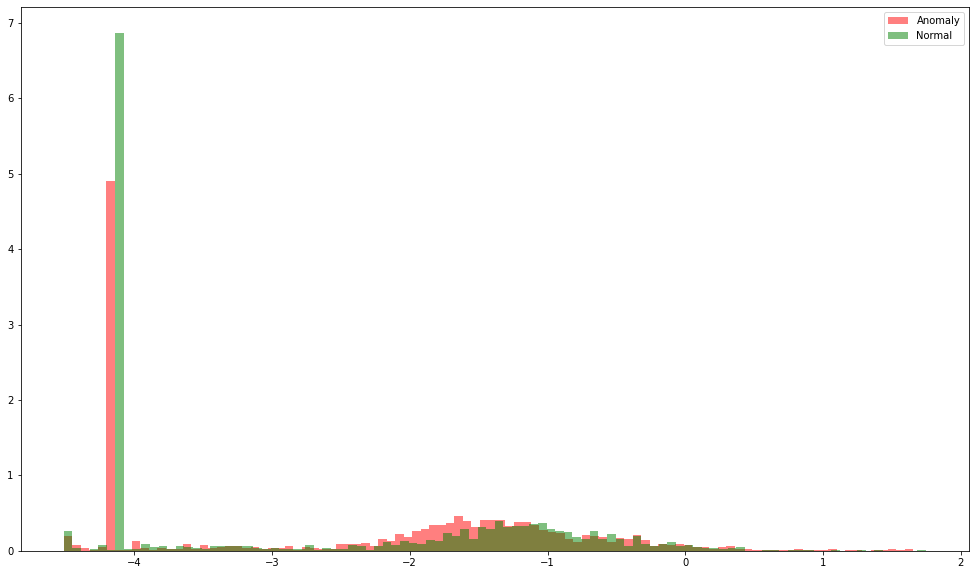

In [30]:
stan_normal_data = normal_pca_data[:,1]
stan_anomaly_data = anomaly_pca_data[:,1]
fig, axs = plt.subplots(1, figsize=(17, 10))
n, anomaly_bins, patches = axs.hist(stan_anomaly_data, 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="Anomaly")
n, norm_bins, patches = axs.hist(stan_normal_data, 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="Normal")
axs.legend()

In [31]:
def plot_simulations(simulations, snd, sad):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(sad, 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly")
    n, bins, patches = axs[0].hist(snd, 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal")
    n, bins, patches = axs[0].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    n, bins, patches = axs[1].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
def plot_lppd(lppds):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(lppds, 200, alpha=0.5, density=True, stacked=True, label="lppd")
    axs[1].plot(range(len(lppds)), lppds, label="lppd")
    axs[0].legend()
    axs[1].legend()
    plt.show()

def train_and_plot(num_of_gaussians, data, anomaly_data):
    mu_loc_prior = 0;
    mu_shape_prior = 2;
    sigma_loc_prior = 0.1;
    sigma_shape_prior = 2;
    theta_loc_prior = 5;
    theta_scale_prior = 5;
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'y':data,
        'k': num_of_gaussians,
        'mu_loc_prior': mu_loc_prior,
        'mu_shape_prior': mu_shape_prior,
        'sigma_loc_prior': sigma_loc_prior,
        'sigma_shape_prior': sigma_shape_prior,
        'theta_loc_prior': theta_loc_prior,
        'theta_scale_prior': theta_scale_prior
    }
    fit = None
    if os.path.isfile('./stan/fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '.pkl'):
        fit = pickle.load(open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta
    

In [32]:
def simulation_and_lppd(mu, sigma, theta, data, anomaly_data):
    simulations, _ = draw_from_GMM(mu, sigma, theta, 1000)
    plot_simulations(simulations, data, anomaly_data)
    lppds, lppd = calc_lppd_vec(mu, sigma, theta, anomaly_data)
    print(lppd)
    plot_lppd(lppds)
    return simulations, lppds

#### 5 Gaussians

(1676,)

Gradient evaluation took 0.002904 seconds
1000 transitions using 10 leapfrog steps per transition would take 29.04 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.003184 seconds
1000 transitions using 10 leapfrog steps per transition would take 31.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00335 seconds
1000 transitions using 10 leapfrog steps per transition would take 33.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.003422 seconds
1000 transitions using 10 leapfrog steps per transition would take 34.22 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 29)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 29)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 

/Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.



 Elapsed Time: 286.533 seconds (Warm-up)
               405.167 seconds (Sampling)
               691.701 seconds (Total)

Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -4.25    0.13   0.18  -4.54  -4.41  -4.18   -4.1   -4.1      2  1.2e4
mu[2]     -4.05     0.1   0.14  -4.25  -4.18  -4.04  -3.91  -3.86      2 7594.2
mu[3]      -2.3    0.77   1.09   -4.1  -3.26  -1.89  -1.42  -1.32      2 3602.2
mu[4]      -1.1    0.13   0.19   -1.3  -1.28  -1.12  -0.92  -0.86      2 585.57
mu[5]      0.48    1.74   2.47  -1.09  -1.04  -0.86   2.28   4.75      2 3845.6
sigma[1]   0.53    0.37   0.53 9.4e-7 1.0e-6   0.52   1.05   1.07      2 7862.3
sigma[2]   0.54    0.32   0.45 9.4e-7   0.19   0.46   0.91   1.26      2 8276.6
sigma[3]   0.81    0.38   0.54 8.3e-7    0.3   0.

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 11073.70it/s]


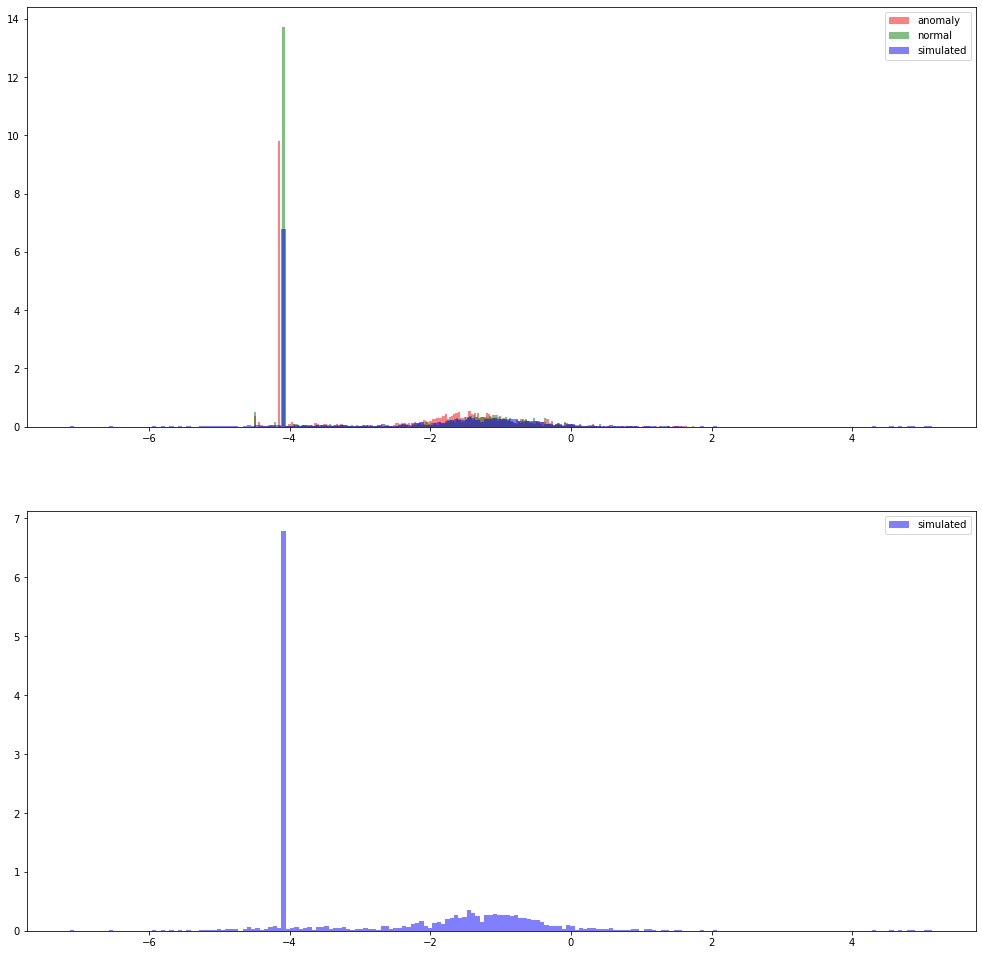

-3914.5317431238623


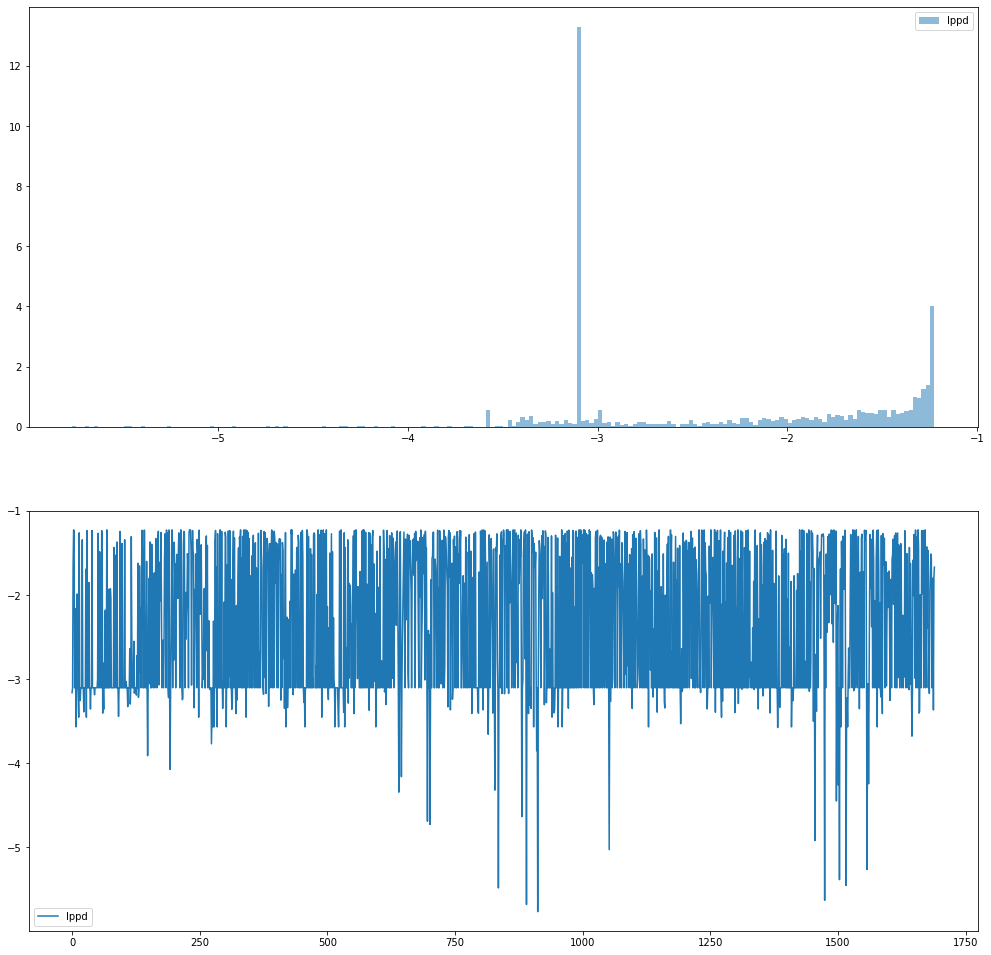

In [33]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
sim, lppds = simulation_and_lppd(mu, sigma, theta, stan_normal_data, stan_anomaly_data)

In [34]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    wlppd, _ = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data[offset_size:offset_size + 100], 5)
    all_lppds.append(wlppd)


(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -4.25    0.13   0.18  -4.54  -4.41  -4.18   -4.1   -4.1      2  1.2e4
mu[2]     -4.05     0.1   0.14  -4.25  -4.18  -4.04  -3.91  -3.86      2 7594.2
mu[3]      -2.3    0.77   1.09   -4.1  -3.26  -1.89  -1.42  -1.32      2 3602.2
mu[4]      -1.1    0.13   0.19   -1.3  -1.28  -1.12  -0.92  -0.86      2 585.57
mu[5]      0.48    1.74   2.47  -1.09  -1.04  -0.86   2.28   4.75      2 3845.6
sigma[1]   0.53    0.37   0.53 9.4e-7 1.0e-6   0.52   1.05   1.07      2 7862.3
sigma[2]   0.54    0.32   0.45 9.4e-7   0.19   0.46   0.91   1.26      2 8276.6
sigma[3]   0.81    0.38   0.54 8.3e-7    0.3   0.93   1.31    1.4      2 4499.3
sigma[4]   0.46    0.02   0.03   0.42   0.43   0.45   0.49   0.51      2 737.25
sigma

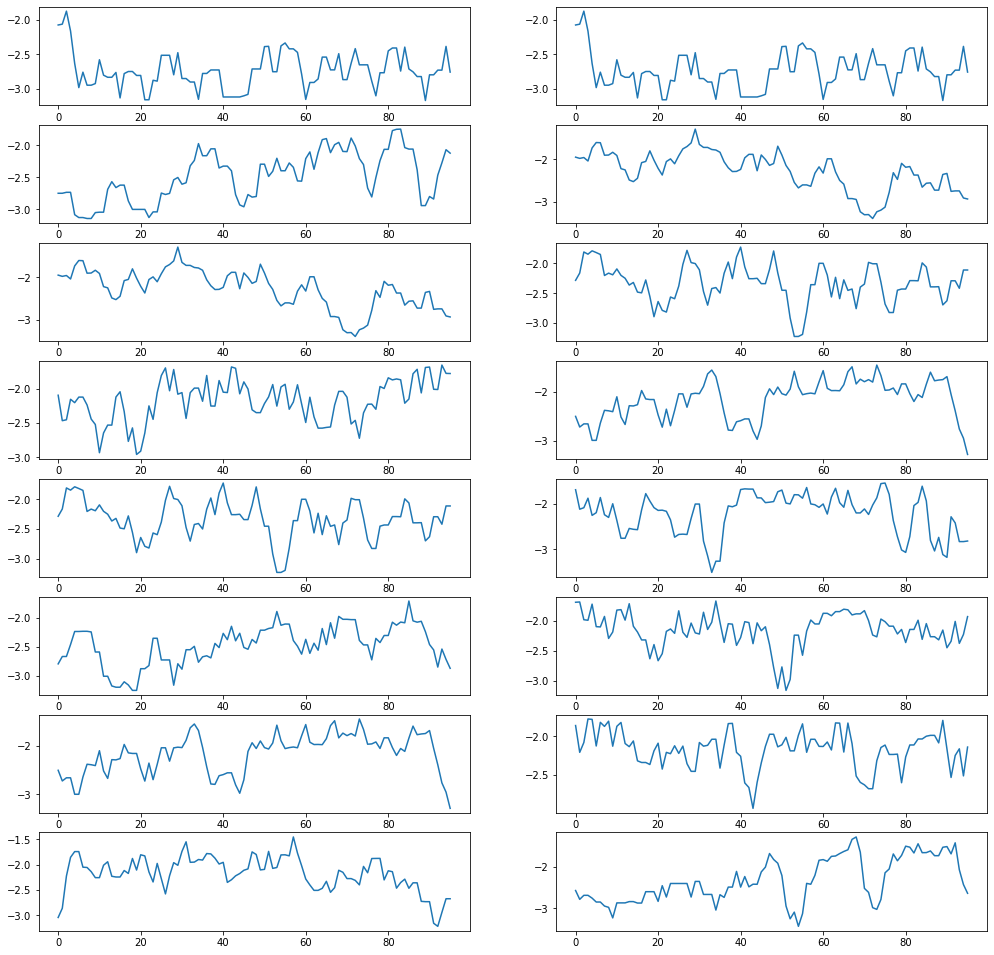

In [35]:
plots_shape = (2,2)
if len(all_lppds) % 3 == 0:
    plots_shape = (int(len(all_lppds)/3), 3)
else:
    plots_shape = (int(len(all_lppds)/2), 2)
fig, axs = plt.subplots(plots_shape[0], plots_shape[1], figsize=(17, 17))
for i in range(plots_shape[0]):
    for j in range(plots_shape[1]):
        axs[i][j].plot(range(len(all_lppds[i * j + i])), all_lppds[i * j + i])
plt.show()

In [36]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, 
                                stan_normal_data[offset_size:offset_size + 100])
    all_lppds.append(lppds)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -4.25    0.13   0.18  -4.54  -4.41  -4.18   -4.1   -4.1      2  1.2e4
mu[2]     -4.05     0.1   0.14  -4.25  -4.18  -4.04  -3.91  -3.86      2 7594.2
mu[3]      -2.3    0.77   1.09   -4.1  -3.26  -1.89  -1.42  -1.32      2 3602.2
mu[4]      -1.1    0.13   0.19   -1.3  -1.28  -1.12  -0.92  -0.86      2 585.57
mu[5]      0.48    1.74   2.47  -1.09  -1.04  -0.86   2.28   4.75      2 3845.6
sigma[1]   0.53    0.37   0.53 9.4e-7 1.0e-6   0.52   1.05   1.07      2 7862.3
sigma[2]   0.54    0.32   0.45 9.4e-7   0.19   0.46   0.91   1.26      2 8276.6
sigma[3]   0.81    0.38   0.54 8.3e-7    0.3   0.93   1.31    1.4      2 4499.3
sigma[4]   0.46    0.02   0.03   0.42   0.43   0.45   0.49   0.51      2 737.25
sigma

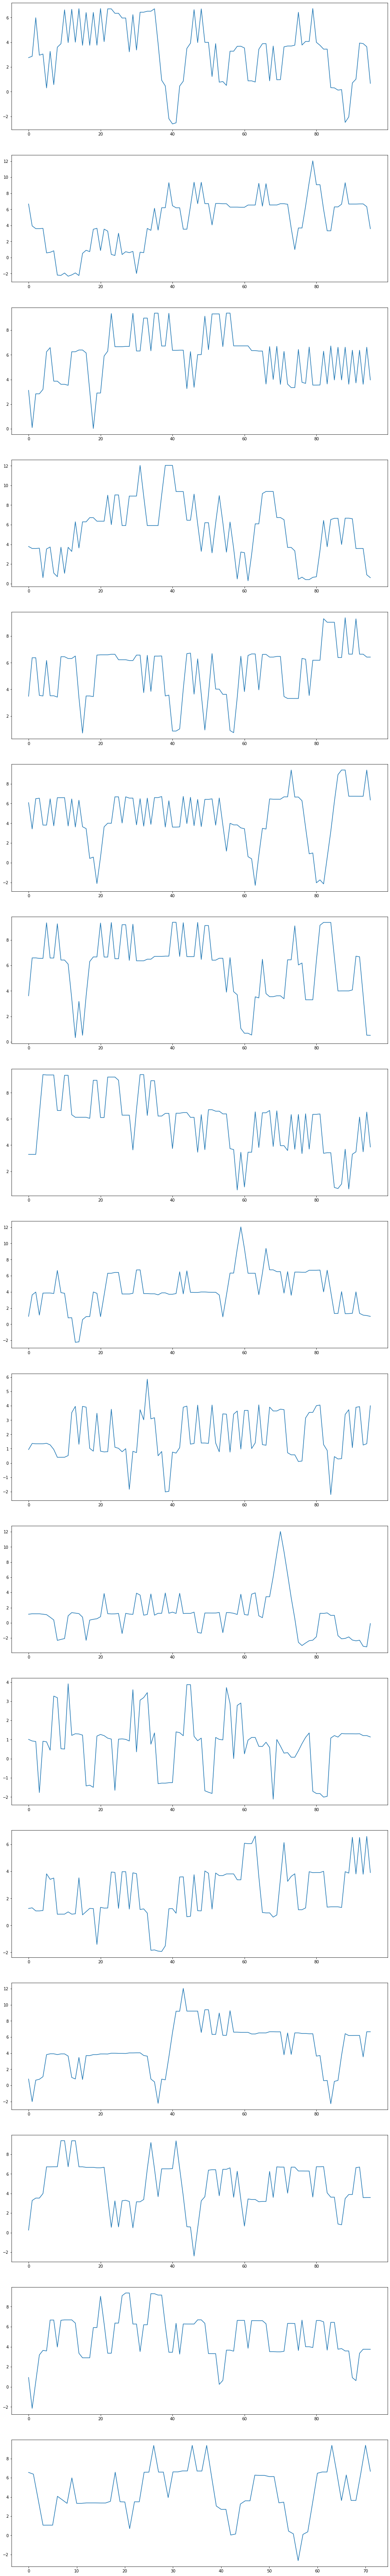

In [37]:
fig, axs = plt.subplots(int(len(all_lppds)), figsize=(17, 7*len(all_lppds)))
for i in range(int(len(all_lppds))):
    axs[i].plot(range(len(all_lppds[i])), all_lppds[i])
plt.show()

In [38]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_norm_lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_normal_data, 5)
all_anomaly_lppds, anom_lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data, 5)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -4.25    0.13   0.18  -4.54  -4.41  -4.18   -4.1   -4.1      2  1.2e4
mu[2]     -4.05     0.1   0.14  -4.25  -4.18  -4.04  -3.91  -3.86      2 7594.2
mu[3]      -2.3    0.77   1.09   -4.1  -3.26  -1.89  -1.42  -1.32      2 3602.2
mu[4]      -1.1    0.13   0.19   -1.3  -1.28  -1.12  -0.92  -0.86      2 585.57
mu[5]      0.48    1.74   2.47  -1.09  -1.04  -0.86   2.28   4.75      2 3845.6
sigma[1]   0.53    0.37   0.53 9.4e-7 1.0e-6   0.52   1.05   1.07      2 7862.3
sigma[2]   0.54    0.32   0.45 9.4e-7   0.19   0.46   0.91   1.26      2 8276.6
sigma[3]   0.81    0.38   0.54 8.3e-7    0.3   0.93   1.31    1.4      2 4499.3
sigma[4]   0.46    0.02   0.03   0.42   0.43   0.45   0.49   0.51      2 737.25
sigma

Text(0.5, 1.0, 'LPPDs')

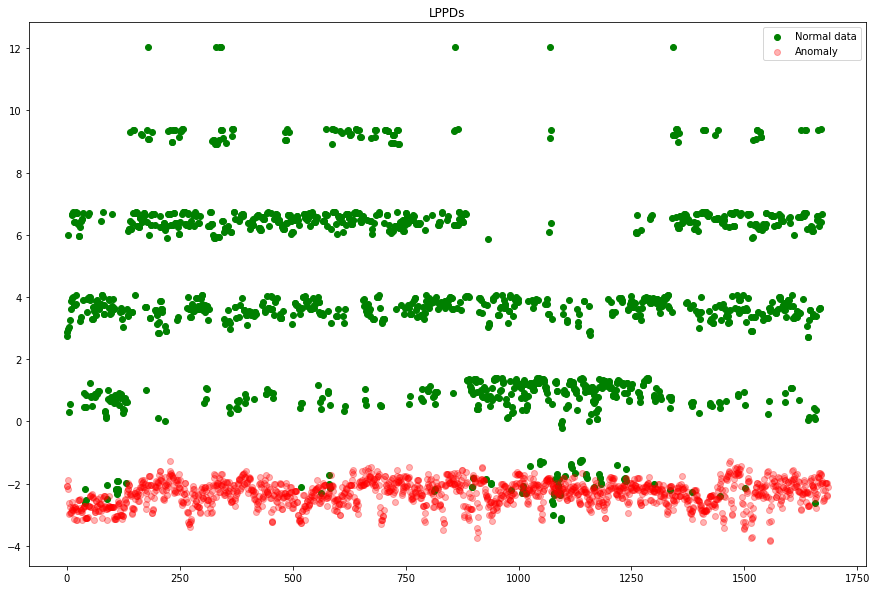

In [42]:
fig, axs = plt.subplots(1, figsize=(15, 10))
emptyData = [None] * (len(all_norm_lppds)-len(all_anomaly_lppds))
all_anomaly_lppds += emptyData
axs.scatter(range(len(all_norm_lppds)), all_norm_lppds, color="g", label="Normal data")
axs.scatter(range(len(all_anomaly_lppds)), all_anomaly_lppds, color="r",alpha=0.3, label="Anomaly")
axs.legend()
axs.set_title('LPPDs')

Try 2,3,4,5 Gaussians

Posterior sampling

2-d GMM

ARVIZ - https://arviz-devs.github.io/arviz/